# Scrape Indeed

### import libraries

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
import re 
import urllib

### define scraping functions

Helper functions copied from class hw.  Make sure you copy the chrome driver into this directory!

In [2]:
#create a webdriver object and set options for headless browsing
options = Options()
options.headless = True
browser = webdriver.Chrome('./chromedriver',options=options)

#uses webdriver object to execute javascript code and get dynamically loaded webcontent
def get_js_soup(url,browser):
    browser.get(url)
    res_html = browser.execute_script('return document.body.innerHTML')
    soup = BeautifulSoup(res_html,'html.parser') #beautiful soup object to be used for parsing html content
    return soup

#tidies extracted text 
def process_bio(bio):
    bio = bio.encode('ascii',errors='ignore').decode('utf-8')       #removes non-ascii characters
    bio = re.sub('\s+',' ',bio)       #repalces repeated whitespace characters with single space
    return bio

''' More tidying
Sometimes the text extracted HTML webpage may contain javascript code and some style elements. 
This function removes script and style tags from HTML so that extracted text does not contain them.
'''
def remove_script(soup):
    for script in soup(["script", "style"]):
        script.decompose()
    return soup

#helper function to write lists to files
def write_lst(lst,file_):
    with open(file_,'w') as f:
        for l in lst:
            f.write(l)
            f.write('\n')
            
# main function that scrapes search result page            
def scrape_search_result_page(dir_url,page_result,browser):
    print ('-'*20,'Scraping indeed search result page '+ str(page_result)+'','-'*20)
    indeed_links = []
    #execute js on webpage to load faculty listings on webpage and get ready to parse the loaded HTML 
    soup = get_js_soup(dir_url,browser) 
    for link_holder in soup.find_all('div',class_='title'): #get list of all <div> of class 'photo nocaption'
        rel_link = link_holder.find('a')['href'] #get url
        #url returned is relative, so we need to add base url
        if rel_link != '':
            indeed_links.append('https://www.indeed.com' + rel_link) 
    print ('-'*20,'Found {} indeed search urls'.format(len(indeed_links)),'-'*20)
    return indeed_links

## Run scraper function

In [3]:
# build query
q = 'python developer' #job query string
l = 'New+York+State' #location of job
numPage = 20 #num pages to scrap links from
allLinks = [] # list to capture
start = 0 #pagnigation variable, page 1 = 0, page 2 = 10, page 3 = 30, etc

# loop over n number of pages
for page_result in range(numPage):
    start = page_result* 10 #increment the variable used to denote the next page
    search_result_url = 'https://www.indeed.com/jobs?q='+ q +'&l='+ l +'&start='+str(start) #build query string
    print(search_result_url)
    jobSearchResult = scrape_search_result_page(search_result_url,page_result, browser) # call scraper function
    allLinks.extend(jobSearchResult) #add to link
    

https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=0
-------------------- Scraping indeed search result page 0 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=10
-------------------- Scraping indeed search result page 1 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=20
-------------------- Scraping indeed search result page 2 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=30
-------------------- Scraping indeed search result page 3 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=40
-------------------- Scraping indeed sea

### write to file for debugging

In [4]:
#Remove Duplicates
print(len(allLinks))
allLinks = list(set(allLinks))
print (len(allLinks))

377
377


In [5]:
print(allLinks)
job_urls_file = 'jobSearchResult' +q+'.txt'
# write to file
write_lst(allLinks,job_urls_file)

['https://www.indeed.com/rc/clk?jk=2a08afea4d6b7c1e&fccid=f770da67b3b51c62&vjs=3', 'https://www.indeed.com/company/EEG/jobs/Front-End-Focused-Software-Developer-cd5e801f6bce8d3f?fccid=504a900e8802863f&vjs=3', 'https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CqDOHIPk8BI5_hSFdy52ydBlxhjoXKXlIYrz_tS6VtlpIDuNggku2YVcGU-rNavCyO8QerRwRluNaZjnTPxwhrTXr6rc5Ty9i629GqtSbV5p3GHIlugY1RVG_LoINxmKiINq6yex0k6AtxTuRGRdrz0BK291lPIUObeq-ks31H-4DkBN65ABUPNFmAVyIKnjI3RLqn2h4HpcIweirNdxLdKx9VyY7ZXvETmdF0sIBQIeiirK-pba5knJOb6xLCQiaQX1SFbaO9pAFN9UKibN7n5lGGbya7Noexlt4LpOfXhbs-sv9h1Tbk0yiNiTEvkBECvipsx18DVbewdsAt7qtwTQ0G_IVvArzFWOL4RSFiNg3GcbtS0anDOCYAQ8kiMVJbT5LXYLqZDwS9mnvqcYAc1hFbx5rtq9p6JFFJV1XLrCRrJaQP77JeSLCH3-aqa9SV2Mik35rPkc3pePYflyI4KLmlc-4bau5KDWbQjMg0lz2cnBoO6fYc7rQxgpS1wGE33SJrbj2Td57WylzJ7jXoj9dioE2xYOjR66FbH4eKS5cdjmQZdRsm9sb-ntvQVEwn2NQfu_bMYKnV3nQ4VOu0IjcKizcKVA7_DHxOQFUOAHGfi9zceMHPe8eLZX5uBoVv845Y8rk1s2O0DSU-tSDit2T2k0GfKUWynGCw8VADBrwErU-1tLaOOZrjbuAkpAKnv2CwmHTgybb8GqrByO3oRQRwJcvOBIP1

## Scrape page data for each link

In [6]:
from gensim.parsing.preprocessing import remove_stopwords

In [7]:
homepage_found = False
page_data = ''
page_data_list = []
for link_num, indeed_url in enumerate(allLinks):
    print("Accessing link",link_num+1,"of",len(allLinks))
    try:
        page_soup = remove_script(get_js_soup(indeed_url,browser)) 
    except:
        print ('Could not access {}'.format(indeed_url))
     
    page_data = process_bio(page_soup.get_text(separator=' '))  #helper function from bio hw to clean up text
    
    #remove header
    page_data = page_data[189:] #the 189 slice removes the header of the indeed pages
    
    #remove footer
    footer_position = page_data.find('save job') #find the position of 'save job' which starts the footer
    trimStringBy = footer_position - len(page_data) #returns a negative number to trim the string by
    page_data = page_data[:trimStringBy] #drop footer
    page_data = remove_stopwords(page_data)
    page_data_list.append(page_data)
    

Accessing link 0 of 377
Accessing link 1 of 377
Accessing link 2 of 377
Accessing link 3 of 377
Accessing link 4 of 377
Accessing link 5 of 377
Accessing link 6 of 377
Accessing link 7 of 377
Accessing link 8 of 377
Accessing link 9 of 377
Accessing link 10 of 377
Accessing link 11 of 377
Accessing link 12 of 377
Accessing link 13 of 377
Accessing link 14 of 377
Accessing link 15 of 377
Accessing link 16 of 377
Accessing link 17 of 377
Accessing link 18 of 377
Accessing link 19 of 377
Accessing link 20 of 377
Accessing link 21 of 377
Accessing link 22 of 377
Accessing link 23 of 377
Accessing link 24 of 377
Accessing link 25 of 377
Accessing link 26 of 377
Accessing link 27 of 377
Accessing link 28 of 377
Accessing link 29 of 377
Accessing link 30 of 377
Accessing link 31 of 377
Accessing link 32 of 377
Accessing link 33 of 377
Accessing link 34 of 377
Accessing link 35 of 377
Accessing link 36 of 377
Accessing link 37 of 377
Accessing link 38 of 377
Accessing link 39 of 377
Accessing 

## Print page data and write to file for debug

**Footer still has some text at the end which isn't properly cleaned

In [8]:
print(page_data_list[1])
document_set = page_data_list
page_data_file = 'pageText' +q+'.txt'
write_lst(page_data_list,page_data_file)

Front-End Focused Software Developer EEG 31 reviews - Brooklyn, NY $60,000 - $90,000 year EEG 31 reviews Read people saying working here. EEG privately-owned media technology company customers including nearly largest broadcasting, cable, OTT/streaming media players United States. Our primary focus video accessibility form closed captions, benefiting deaf hard-of-hearing, language learners, watched video mute. Our pioneering role IP-based live captioning systems recognized EEG received Science & Technology Emmy award 2015. We talented growing staff focusing fast-paced solutions customer-focused challenges new ultra-HD IP-driven media formats, artificial intelligence automation, migration video production technology cloud-powered platforms workflows. The position in-person job EEG's R&D office DUMBO neighborhood Brooklyn, working casual fun environment. Responsibilities We seeking software developer focus front-end design create enhance interactive applications cloud services platform e

## Summarization Using Text Rank

### import libraries

In [9]:
from gensim.summarization import keywords
from gensim.summarization.summarizer import summarize
from gensim.summarization import mz_keywords

In [10]:
# Create single document by concatenating all documents
all_documents = ""

for doc in page_data_list:
    all_documents += doc

In [11]:
#keywords
keywords(all_documents).split('\n')


['developer',
 'developments',
 'developed',
 'developers',
 'develope',
 'experiences',
 'experiments',
 'experiment',
 'working',
 'works',
 'teams',
 'programming experience',
 'developing robust',
 'new',
 'news',
 'technologies',
 'application',
 'applicant',
 'engineers develop impactful solutions',
 'excited experimenting',
 'requires',
 'requirements',
 'required',
 'requiring',
 'web development tools strong',
 'develops executes database',
 'software',
 'include',
 'included',
 'build',
 'building',
 'production',
 'products',
 'productivity',
 'productive',
 'engineer',
 'engineering',
 'engine',
 'management',
 'manager',
 'manages',
 'managers',
 'managed',
 'designers',
 'designing',
 'designation',
 'designer',
 'designated',
 'solution',
 'companys',
 'python',
 'providing',
 'provided',
 'provide',
 'provides',
 'provider',
 'providers',
 'businesses',
 'knowledgeable',
 'support',
 'supported',
 'supportive',
 'supporting',
 'supportability',
 'supportable',
 'codes',

In [12]:
print(summarize(all_documents, word_count  = 250))

Provide complete solutions reduce manual interventions injecting significant business value entire organization Qualifications BSc Computer Science equivalent 5+ years relevant professional experience 3yrs+ Java development experience Linux 3yrs+ JavaScript Shell script experience 3yrs+ Automated quality control environment 5yrs+ experience iterative development automated build pipelines Proficiency people interaction Key Success Role Strong communications consultation skills Intellectual agility interpersonal flexibility Technical competency solid process quality control orientation Ability collaborate develop long-term relationships Curiosity learn instill new paradigms Top 3 Personal Competencies Possess Drive Execution Be accountable strong individual team performance Customer Focus Deliver prompt high-quality customer service Partnership Build trust strong partnerships self-ownership teams actions Preferred Skills Experience Python Experience high performance trading risk platform

In [13]:
print(mz_keywords(all_documents,scores=True,threshold=0.001))

/Users/brianyoo/anaconda3/lib/python3.6/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/brianyoo/anaconda3/lib/python3.6/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


[('qlikview', 0.005018712711738003), ('gis', 0.0036691505362333537), ('we', 0.003527237397301303), ('ibm', 0.0029968185767694317), ('data', 0.0028705903552422416), ('google', 0.0028301853163520646), ('trading', 0.0024206226682722664), ('arcgis', 0.002344654741086663), ('oriented', 0.0022470683080693817), ('seen', 0.002233920300337529), ('quantum', 0.002122546131684016), ('companies', 0.002112552690803926), ('experience', 0.002044436899546405), ('d', 0.0019735108762266593), ('triplebyte', 0.0017193489179141803), ('cornell', 0.0016252934543810689), ('blackrock', 0.001606180954519147), ('financial', 0.0016057649344545235), ('analytics', 0.001561023326983403), ('hadoop', 0.0015569593999197901), ('you', 0.0015455757176429344), ('code', 0.0015386204530200627), ('talent', 0.001518561255814204), ('developer', 0.0015004517808290053), ('business', 0.0014642610790857045), ('computing', 0.0014367885089259748), ('estate', 0.0014307335624122554), ('software', 0.001395393601127816), ('get', 0.0013769

# Topic Modeling

### import libraries

In [14]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models.wrappers import LdaMallet
from pprint import pprint


### tokenize the documents

In [15]:
docs = page_data_list

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are less than 3 characters.
docs = [[token for token in doc if len(token) > 3] for doc in docs]

must download wordnet!!!

In [16]:
 # nltk.download('wordnet')

### lemmatize the documents

In [17]:
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

### compute bigrams

In [18]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

### remove rare and common tokens

In [19]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.75)

In [20]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [21]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1626
Number of documents: 377


## Build LDA Model

In [22]:
# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [23]:
num_top_words = 10
top_topics = lda_model.top_topics(corpus, topn=num_top_words) 
# print(top_topics)
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Average topic coherence: -0.8724.
Topic: 0 
Words: 0.001*"university" + 0.001*"applicant" + 0.001*"technology" + 0.001*"including" + 0.001*"management" + 0.001*"client" + 0.001*"planning" + 0.001*"application" + 0.001*"visit" + 0.001*"online"
Topic: 1 
Words: 0.045*"risk" + 0.045*"java" + 0.023*"senior" + 0.023*"service" + 0.008*"risk_management" + 0.008*"implement" + 0.008*"management" + 0.008*"optimize" + 0.008*"financial" + 0.008*"existing"
Topic: 2 
Words: 0.013*"oriented" + 0.011*"arcgis" + 0.010*"strong" + 0.010*"knowledge" + 0.008*"real" + 0.008*"estate" + 0.007*"enjoys" + 0.007*"location" + 0.007*"people" + 0.007*"skill"
Topic: 3 
Words: 0.022*"backend" + 0.020*"data" + 0.014*"engineering" + 0.013*"development" + 0.012*"based" + 0.011*"platform" + 0.011*"building" + 0.011*"design" + 0.011*"build" + 0.011*"apis"
Topic: 4 
Words: 0.028*"contract" + 0.025*"software" + 0.024*"myticas" + 0.017*"financial" + 0.017*"looking" + 0.017*"backend" + 0.017*"consulting" + 0.017*"engineering"

## Visualize Topics

In [266]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

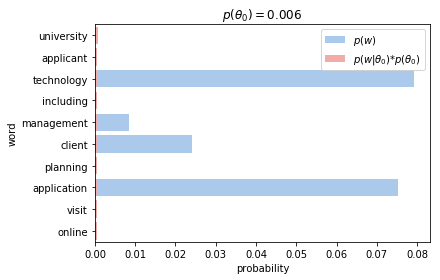

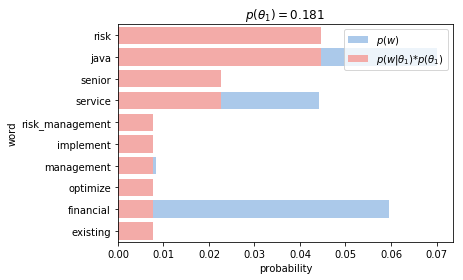

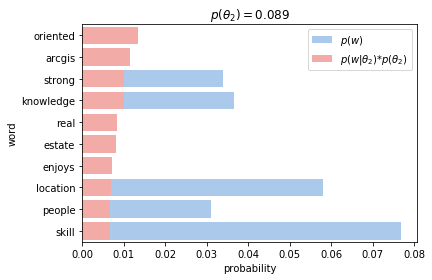

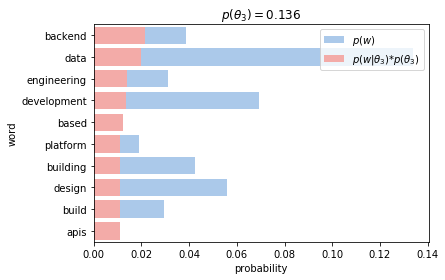

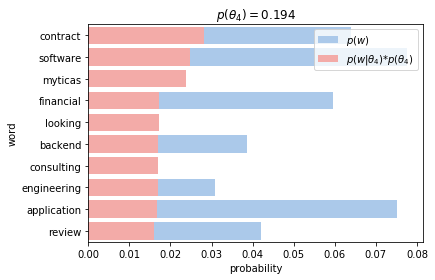

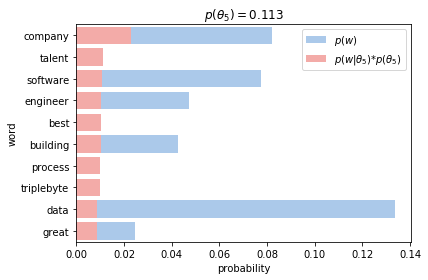

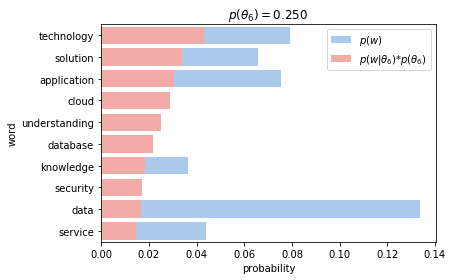

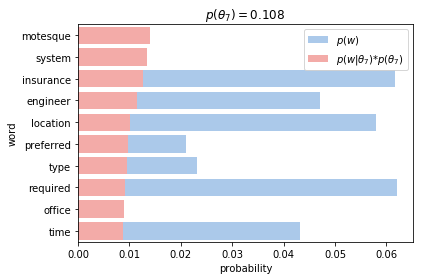

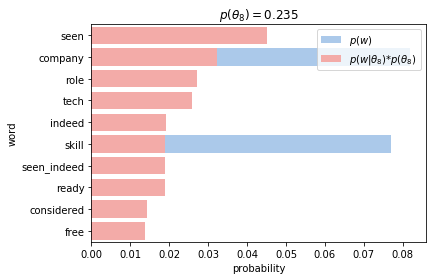

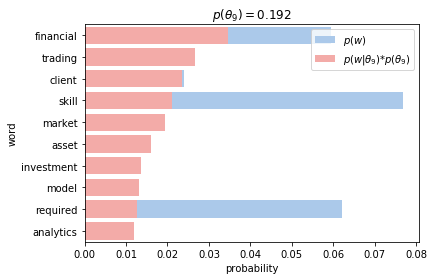

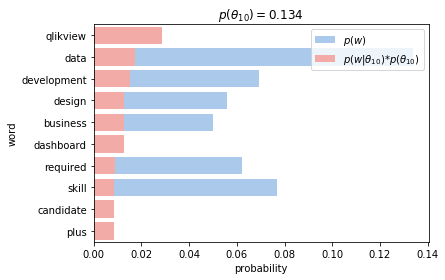

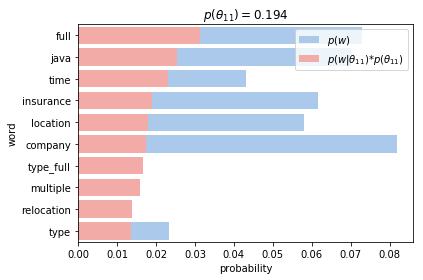

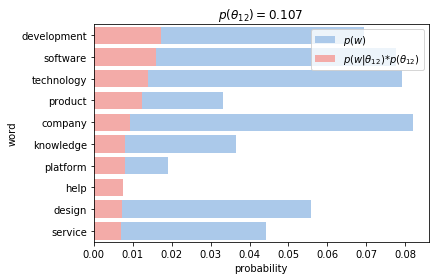

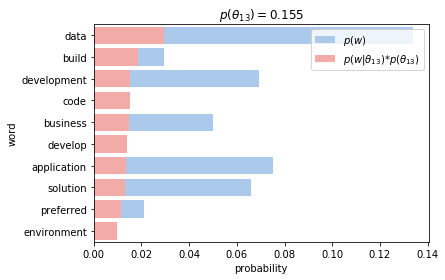

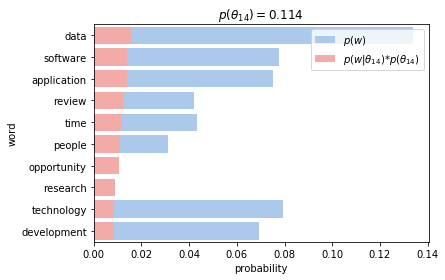

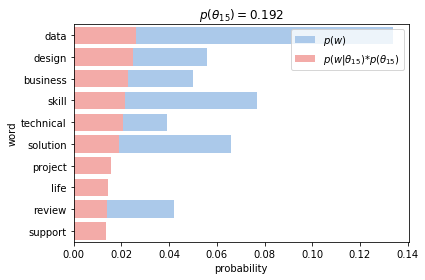

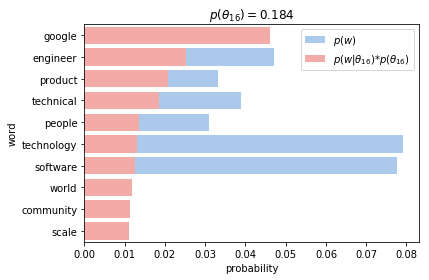

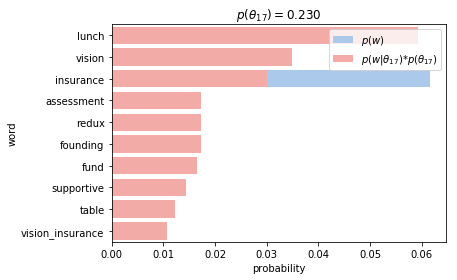

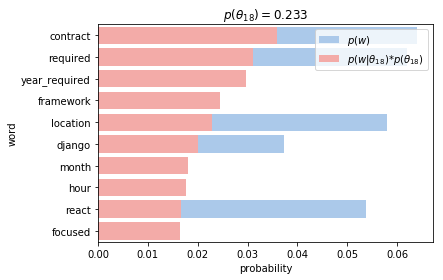

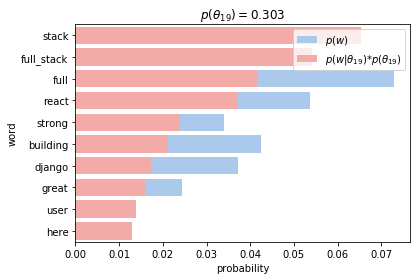

In [355]:
#visualize without sorting topics

# initialize
topic_v = np.zeros(num_topics)
p_word_topic = []
word = []
topic_number_idx = []

# create dataframe containing prob_word_given_topic, words, and topic number from lda_model
for i in range(num_topics):

    word_id, prob, = zip(*lda_model.get_topic_terms(i))
    for j in range(len(word_id)):
        p_word_topic.append(prob[j])
        word.append(id2word[word_id[j]])
        topic_number_idx.append(i)
        
dict = {'p_word_topic': p_word_topic,
        'word': word,
        'topic_number_idx': topic_number_idx,
       }
df = pd.DataFrame(dict) 

# add the sum of the probabilities as a separate column
# note: there are duplicates for words that occur more than once
df['p_total'] = df.groupby(['word'])['p_word_topic'].transform('sum')


# iterate over each topic
for n in df.topic_number_idx.unique():
    # create dataframe containing only n topic data
    df_sparse = df[df['topic_number_idx']==n]
    
    # create separate dataframe for word probability
    # we need to drop rows with duplicate (word,p_word_topic) entries (see note above)
    df.drop_duplicates(subset=['word', 'p_word_topic'])
    df_sparse_total = df[df['topic_number_idx']==n]
    
    # create plot for each topic
    plt.figure()
    sns.set_color_codes("pastel")
    # create barplot total word probability
    sns.barplot(x='p_total',y='word',data=df_sparse_total,color='b',alpha = 1,label=r'$p(w)$')
    # overlay barplot with relative word probability
    # note that sum(p(w|theta))==1 (sum over words in topic), therefore the data we are plotting is p(w|theta)*p(theta)
    sns.barplot(x='p_word_topic',y='word',data=df_sparse,color='r',alpha =1,label=r'$p(w|\theta_{'+str(n)+'})$'+r'*$p(\theta_{'+str(n)+'})$')
    
    plt.title(r'$p(\theta_{'+str(n)+'})=$'+str('%0.3f'%(df_sparse.p_word_topic.sum())))
    plt.legend(loc='upper right')
    plt.xlabel('probability')
    
plt.show()

In [341]:
df

,p_word_topic,word,topic_number_idx,p_total
0,0.000635,university,0,0.000635
1,0.000632,applicant,0,0.000632
2,0.000628,technology,0,0.079182
3,0.000627,including,0,0.000627
4,0.000627,management,0,0.008388
5,0.000627,client,0,0.024026
6,0.000627,planning,0,0.000627
7,0.000626,application,0,0.075228
8,0.000626,visit,0,0.000626
9,0.000626,online,0,0.000626


### PCA

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

perform PCA on topic coverage matrix then plot doc topics within principle component (2) latent space

number of documents: 377


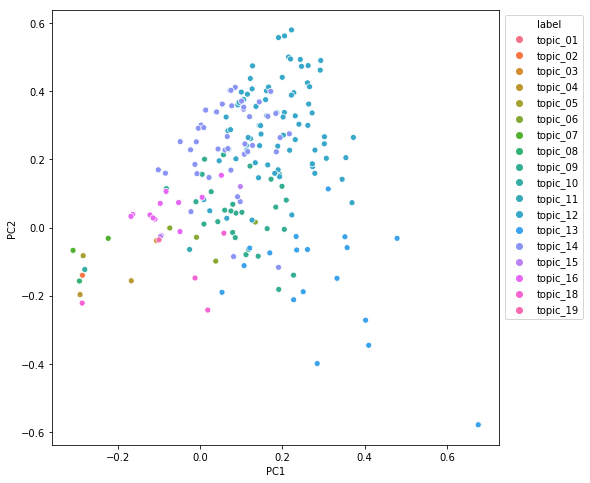

In [363]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA


# PCA of topic coverage
# (shape: num_docs * number_topics
topic_coverage = []

print(lda_model[corpus])
for i, row_list in enumerate(lda_model[corpus]):
    # row list contains list of topic number and probability of topic as a tuple
    # note that each doc can have multiple topics
    
    # initialize zero list
    r = np.zeros(num_topics)

    topic_n, p_topic =zip(*row_list)
    
    # store topic prob into r
    for i in range(len(row_list)):
        r[topic_n[i]]=p_topic[i]
    topic_coverage.append(r)

# should return array with len(num_docs) and entries ~1
# print((np.sum(topic_weights,axis=1)))
# should return shape of num_docs * num_topics
# print(np.shape(topic_weights))

# Array of topic weights
X = pd.DataFrame(topic_coverage).fillna(0).values

# only look at the first two components
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# dominant topic number in each doc
topic_num = np.argmax(X, axis=1)

plt.figure(figsize=(8,8))

print('number of documents:',len(lda_model[corpus]))
labels=['topic_'+"%02d" %(x) for x in range(num_topics+1)]

# create dataframe of containing latent space coordinates for each topic labeled document
df_topic_coverage = pd.DataFrame({'x':result[:,0],'y':result[:,1],'label':[labels[x] for x in topic_num]}).sort_values(by='label')
sns.scatterplot(x=df_topic_coverage.x, y=df_topic_coverage.y, hue=df_topic_coverage.label, data =df_topic_coverage)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend( bbox_to_anchor=[1.2, 1.0])

plt.show()


### t-SNE

perform t-SNE on topic coverage then plot doc topics within t-SNE latent space

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.001s...
[t-SNE] Computed neighbors for 377 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 0.252795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.057972
[t-SNE] KL divergence after 1000 iterations: -2.788681
number of documents: 377


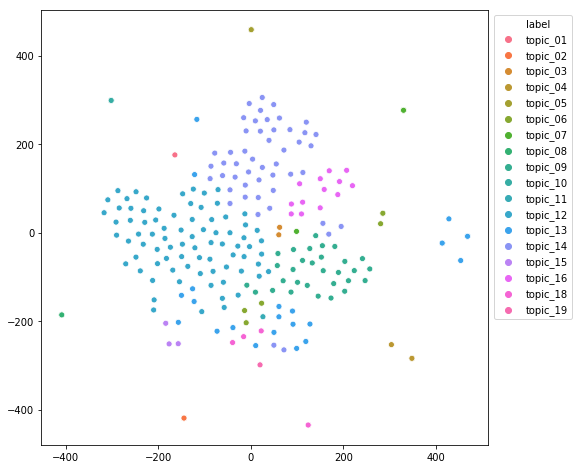

In [297]:
from sklearn.manifold import TSNE

# TSNE by topic coverage

# Dominant topic number in each doc
topic_num = np.argmax(X, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(X)

# Plot the Topic Clusters
print('number of documents:',len(tsne_lda))
plt.figure(figsize=(8,8))
df_topic_coverage = pd.DataFrame({'x':tsne_lda[:,0],'y':tsne_lda[:,1],'label':[labels[x] for x in topic_num]}).sort_values(by='label')
sns.scatterplot(x=df_topic_coverage.x, y=df_topic_coverage.y, hue=df_topic_coverage.label, data =df_topic_coverage)
plt.legend( bbox_to_anchor=[1.2, 1.0])
plt.xlabel('')
plt.ylabel('')
plt.show()


### Visualize using pyLDAvis

Here we will visualize the topic models using pyLDAvis.
ref: http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

Example Notebook: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#topic=0&lambda=1&term=

NOTE: not exactly sure what feature matrix they did PCA on

In [30]:
# make sure to pip install pyldavis to run visualization

In [31]:
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [32]:
pyLDAvis.enable_notebook()

In [33]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.059031  0.034618       1        1  13.584182
5     -0.186670  0.064653       2        1  13.303786
12     0.137275  0.035294       3        1  12.426138
13     0.167158  0.064803       4        1  12.313658
10     0.049812  0.090124       5        1  10.781262
14     0.135245  0.040099       6        1   9.855470
7     -0.023636  0.040876       7        1   6.059168
9      0.174866 -0.030866       8        1   4.714315
16     0.166633  0.031981       9        1   3.496118
8     -0.066737 -0.288942      10        1   3.437838
18    -0.119659 -0.268864      11        1   3.063612
4      0.033539 -0.255316      12        1   2.706743
6      0.198454 -0.022103      13        1   2.406548
15     0.121051  0.049118      14        1   1.164924
3     -0.046591  0.050566      15        1   0.243188
19    -0.083125  0.055273      16        1   0.210298
11    -0.168344  0.058644      17        1   0.115685
1     -0.098435  0.054897      18        1   0.065253
17    -0.184372  0.105499      19        1   0.045989
0     -0.147432  0.089647      20        1   0.005830, topic_info=     Category        Freq                  Term       Total  loglift  logprob
term                                                                         
142   Default  312.000000             insurance  312.000000  30.0000  30.0000
11    Default  933.000000                  data  933.000000  29.0000  29.0000
24    Default  279.000000                  full  279.000000  28.0000  28.0000
96    Default  688.000000               company  688.000000  27.0000  27.0000
64    Default  470.000000                  time  470.000000  26.0000  26.0000
108   Default  774.000000           development  774.000000  25.0000  25.0000
31    Default  184.000000                  java  184.000000  24.0000  24.0000
62    Default  562.000000            technology  562.000000  23.0000  23.0000
197   Default  328.000000               service  328.000000  22.0000  22.0000
208   Default  385.000000                strong  385.000000  21.0000  21.0000
153   Default  354.000000              location  354.000000  20.0000  20.0000
238   Default  364.000000                 build  364.000000  19.0000  19.0000
107   Default  487.000000                design  487.000000  18.0000  18.0000
239   Default  465.000000              business  465.000000  17.0000  17.0000
354   Default  317.000000              building  317.000000  16.0000  16.0000
326   Default  550.000000                 skill  550.000000  15.0000  15.0000
1     Default  632.000000           application  632.000000  14.0000  14.0000
57    Default  381.000000              solution  381.000000  13.0000  13.0000
16    Default  384.000000              engineer  384.000000  12.0000  12.0000
898   Default  278.000000              qlikview  278.000000  11.0000  11.0000
501   Default  117.000000                vision  117.000000  10.0000  10.0000
204   Default  122.000000                 stack  122.000000   9.0000   9.0000
17    Default  335.000000           engineering  335.000000   8.0000   8.0000
55    Default  753.000000              software  753.000000   7.0000   7.0000
491   Default  314.000000               product  314.000000   6.0000   6.0000
558   Default  398.000000              required  398.000000   5.0000   5.0000
319   Default  117.000000                  risk  117.000000   4.0000   4.0000
93    Default  362.000000                  code  362.000000   3.0000   3.0000
468   Default  207.000000             financial  207.000000   2.0000   2.0000
91    Default  316.000000             candidate  316.000000   1.0000   1.0000
...       ...         ...                   ...         ...      ...      ...
98    Topic20    0.003239            consistent   27.495749   0.7035  -7.3895
787   Topic20    0.003239                  unix   28.611437   0.6636  -7.3897
1339  Topic20    0.003236           aff

# Deprecated

### use coherence to sort dataframes (deprecated since the topic numbers get re-indexed)

In [268]:
# def create_df_from_top_topics(top_topics):
#     ''' function that coverts lda_model.top_topics() data into pandas dataframe
#     '''
#     # initialize empty lists
#     p_word_topic = []
#     word = []
#     coherence = []
#     topic_number_idx = []
    
#     # loop through topics
#     for t, topic in enumerate(top_topics):
        
#         # obtain probability and word vectors
#         p_vec,w_vec = zip(*topic[0])
#         for p,w in zip(p_vec,w_vec):
#             p_word_topic.append(p)
#             word.append(w)
#             coherence.append(topic[1])
#             topic_number_idx.append(t)
    
#     # covert lists to dict
#     dict = {'p_word_topic': p_word_topic,
#             'word': word,
#             'coherence': coherence,
#             'topic_number_idx': topic_number_idx,
#            }
    
#     return pd.DataFrame(dict)
        
# df = create_df_from_top_topics(top_topics)

In [288]:
# # sorted by top topics (coherence measure)
# for n in df.topic_number_idx.unique():
#     df_sparse = df[df['topic_number_idx']==n]
    
#     plt.title('topic '+str(n)+', coherence='+str('%4.3f'%df_sparse.coherence.mean()))
#     sns.barplot(x='p_word_topic',y='word',data=df_sparse,color='b',alpha = 0.6)
# #     print(df_sparse)
#     plt.xlabel('likelihood')
# #     plt.xlim([0, max(df.p_word_topic)])
# plt.show()
    

### Additional EDA (won't pursue)

In [364]:
# PCA by LDA -> word2vec

# # TODO: might need to re-weigh the sentence based on their probabilities
# topic_sentence = []
# for topic in top_topics:
#     p_vec,w_vec = zip(*topic[0])
#     topic_sentence.append(w_vec)
    
# # train model by creating word2vec neural network
# model = Word2Vec(topic_sentence, min_count=1)

# # fit a 2d PCA model to the vectors
# X = model[model.wv.vocab]
# print(np.shape(X))

# # only look at the first two components
# pca = PCA(n_components=2)
# result = pca.fit_transform(X)

# # create a scatter plot of the projection
# plt.figure(figsize=(8,8))

# pca1 = result[:, 0]
# pca2 = result[:, 1]


# plt.scatter(pca1, pca2)
# words = list(model.wv.vocab)

# for i, word in enumerate(words):
# #     print(word)
#     plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

# df_topic_weight = pd.DataFrame({'x':result[:,0],'y':result[:,1],'label':[labels[x] for x in topic_num]}).sort_values(by='label')
# sns.scatterplot(x=df_topic_weight.x, y=df_topic_weight.y, hue=df_topic_weight.label, data =df_topic_weight)
# plt.legend( bbox_to_anchor=[1.15, 0.5], loc='center')
# plt.xlabel('')
# plt.ylabel('')
# plt.show()


# TODO: need to group each word with topics, then plot centroid + 95% CI. 
# Should look something similar pyldavis plot

## Build LSI Model (deprecated)

older topic model

In [ ]:
# Build the LSI Model
lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=10, decay=0.5)

In [ ]:
pprint(lsi_model.print_topics(-1))

## Build HDP Model (deprecated)

HDP model determines number of topics automatically

In [ ]:
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
pprint(hdp_model.show_topics())